In [1]:
from PIL import Image

In [7]:
name_example = r"D:\deepfakes\extracted_real_images\dhjnjkzuhq_10.png"

In [10]:
img = Image.open(name_example).convert("RGB")

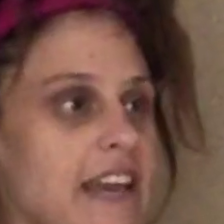

In [11]:
img

In [12]:
import insightface

In [16]:
import cv2

In [18]:
import numpy as np

In [13]:
face_detector = insightface.model_zoo.get_model('retinaface_r50_v1')
face_detector.prepare(ctx_id=0, nms=0.4)

[32, 16, 8] {'32': {'SCALES': (32, 16), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}, '16': {'SCALES': (8, 4), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}, '8': {'SCALES': (2, 1), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}}
use_landmarks True


In [57]:
example_video = r"D:\deepfakes\real_video_examples\dhjnjkzuhq.mp4"

In [58]:
def put_to_center(img, input_size):
    img = img[:input_size, :input_size]
    image = np.zeros((input_size, input_size, 3), dtype=np.uint8)
    start_w = (input_size - img.shape[1]) // 2
    start_h = (input_size - img.shape[0]) // 2
    image[start_h:start_h + img.shape[0], start_w: start_w + img.shape[1], :] = img
    return image


def isotropically_resize_image(img, size, interpolation_down=cv2.INTER_AREA, interpolation_up=cv2.INTER_CUBIC):
    h, w = img.shape[:2]
    if max(w, h) == size:
        return img
    if w > h:
        scale = size / w
        h = h * scale
        w = size
    else:
        scale = size / h
        w = w * scale
        h = size
    interpolation = interpolation_up if scale > 1 else interpolation_down
    resized = cv2.resize(img, (int(w), int(h)), interpolation=interpolation)
    return resized

In [81]:
transformed = []

In [79]:
from torchvision import transforms
import torch
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
transformation = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=MEAN, std=STD)
        ])

In [82]:
capturator = cv2.VideoCapture(example_video)
frames_number = int(capturator.get(cv2.CAP_PROP_FRAME_COUNT))
width = int(capturator.get(cv2.CAP_PROP_FRAME_WIDTH))
scale = 1.0

for i in range(frames_number):
    capturator.grab()
    if i % 20 == 0:
        success, frame = capturator.retrieve()
        if not success:
            continue

        if width <= 300:
            scale = 2.0
        elif 1000 < width <= 1900:
            scale = 0.5
        elif width > 1900:
            scale = 0.33


        bounding_box, _ = face_detector.detect(frame, threshold=0.7, scale=scale)
        if bounding_box.shape[0] == 0:
            continue

        x_min = bounding_box[:, 0]
        y_min = bounding_box[:, 1]
        x_max = bounding_box[:, 2]
        y_max = bounding_box[:, 3]

        areas = (y_max - y_min) * (x_max - x_min)
        max_face_idx = areas.argmax()

        w = x_max[max_face_idx] - x_min[max_face_idx]
        h = y_max[max_face_idx] - y_min[max_face_idx]

        margin_width = w // 4
        margin_height = h // 4

        frame = frame[max(int(y_min[max_face_idx] - margin_height), 0):int(y_max[max_face_idx] + margin_height),
                      max(int(x_min[max_face_idx] - margin_width), 0):int(x_max[max_face_idx] + margin_width)]
        resized_face = isotropically_resize_image(frame, 224)
        resized_face = put_to_center(resized_face, 224)
        transformed_image = Image.fromarray(frame[:, :, ::-1])
        transformed_image = transformation(transformed_image)
#         transformed_image = Image.fromarray(frame)
        transformed.append(transformed_image)

capturator.release()

In [70]:
len(transformed)

15

In [84]:
print(torch.max(transformed[0]))

tensor(1.6583)


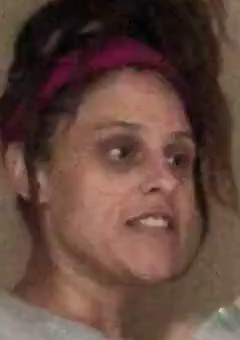

In [71]:
transformed[0]

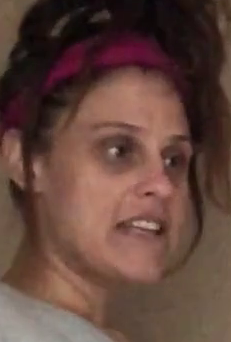

In [72]:
transformed[1]

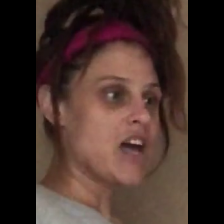

In [64]:
transformed[2]

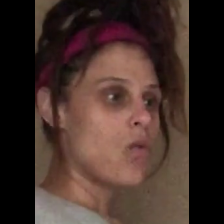

In [65]:
transformed[3]

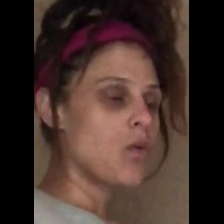

In [66]:
transformed[4]

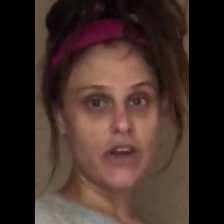

In [67]:
transformed[14]

In [2]:
img = Image.open("real_image_name").convert("RGB")

FileNotFoundError: [Errno 2] No such file or directory: 'real_image_name'

# Same Transformations

In [8]:
import albumentations as A
import cv2

In [22]:
transform = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.RGBShift(p=0.2),
    ],
    additional_targets={'image2': 'image'}
)

In [51]:
image1 = cv2.imread('D:/deepfakes/extracted_real_images/lzbmwwejxb_280.png')
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2 = cv2.imread('D:/deepfakes/extracted_real_images/fopjiyxiqd_20.png')
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

In [52]:
transformed = transform(image=image1, image2=image2)

In [53]:
from matplotlib import pyplot as plt

In [54]:
def visualize(image):
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(image)

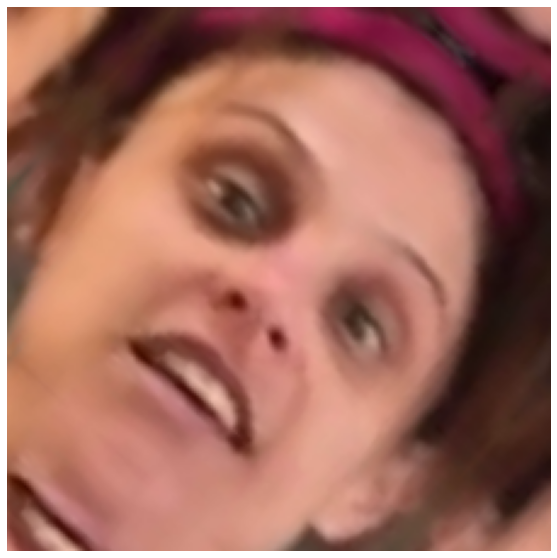

In [55]:
visualize(transformed['image'])

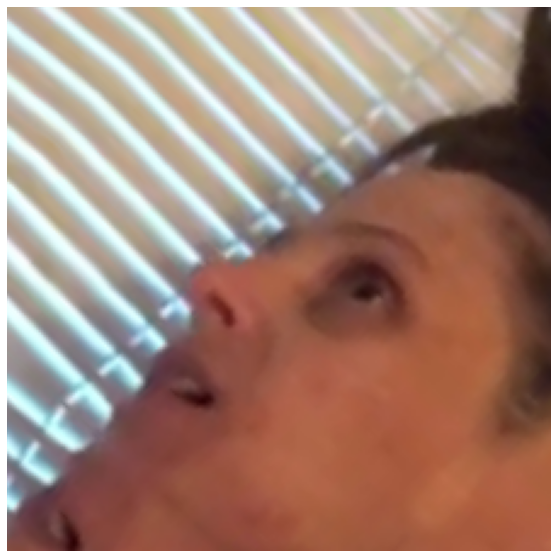

In [56]:
visualize(transformed['image2'])

In [50]:
transformed.keys()

dict_keys(['image', 'image2'])